In [1]:
from pathlib import Path

project_dir = Path('.').absolute().parent
project_dir

PosixPath('/home/daniel/Documents/github/mcx-lab/rl-baselines3-zoo')

In [2]:
import gym
import utils.import_envs

env = gym.make('A1GymEnv-v0', gait_name='trot')
env.observation_space.shape
print(env.all_sensors())
foot_names = env.robot.GetFootNames()
print(foot_names)

pybullet build time: Jan 19 2022 23:07:37


Init CPG gait=trot, duty_factor=0.5, period=0.6666666666666666
argv[0]=
[<blind_walking.envs.sensors.robot_sensors.BaseVelocitySensor object at 0x7fb85475a190>, <blind_walking.envs.sensors.robot_sensors.IMUSensor object at 0x7fb85475a100>, <blind_walking.envs.sensors.robot_sensors.MotorAngleSensor object at 0x7fb85475a1c0>, <blind_walking.envs.sensors.robot_sensors.MotorVelocitySensor object at 0x7fb73ef44cd0>, <blind_walking.envs.sensors.environment_sensors.LastActionSensor object at 0x7fb73ef44c70>, <blind_walking.envs.sensors.environment_sensors.ForwardTargetPositionSensor object at 0x7fb73ef50280>, <blind_walking.envs.sensors.cpg_sensors.ReferenceGaitSensor object at 0x7fb73ef50370>]
['FR_toe_fixed', 'FL_toe_fixed', 'RR_toe_fixed', 'RL_toe_fixed']


/home/daniel/anaconda3/envs/rl-baselines-zoo-cu113/lib/python3.8/site-packages/gym/logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


# Inspect logged inputs / outputs

Logs generated with `scripts/enjoy_with_logging.py`

In [3]:
import numpy as np
import pickle 

def load_robot_states(stats_dir):
    motor_position = np.load(stats_dir / 'motor_position.npy')
    print(motor_position.shape)
    motor_velocity = np.load(stats_dir / 'motor_velocity.npy')
    feet_air_time = np.load(stats_dir / 'feet_air_time.npy')
    print(feet_air_time.shape)
    nn_observations = np.load(stats_dir / 'nn_observations.npy')
    print(nn_observations.shape)
    nn_actions = np.load(stats_dir / 'nn_actions.npy')
    print(nn_actions.shape)
    time = np.load(stats_dir / 'time.npy')
    
    return time, motor_position, motor_velocity, feet_air_time, nn_observations, nn_actions

def load_normalizer(model_dir):
    with open(model_dir / 'A1GymEnv-v0' / 'vecnormalize.pkl', 'rb') as file:
        normalizer = pickle.load(file)
    return normalizer

(1000, 12)
(1000, 4)
(1000, 1, 66)
(1000, 1, 12)
[47.50000061 47.49999865 47.50000064 47.00000019]


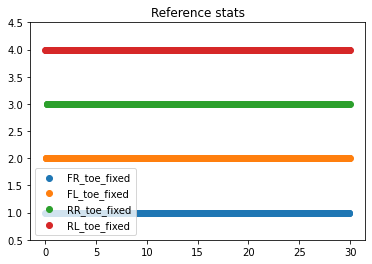

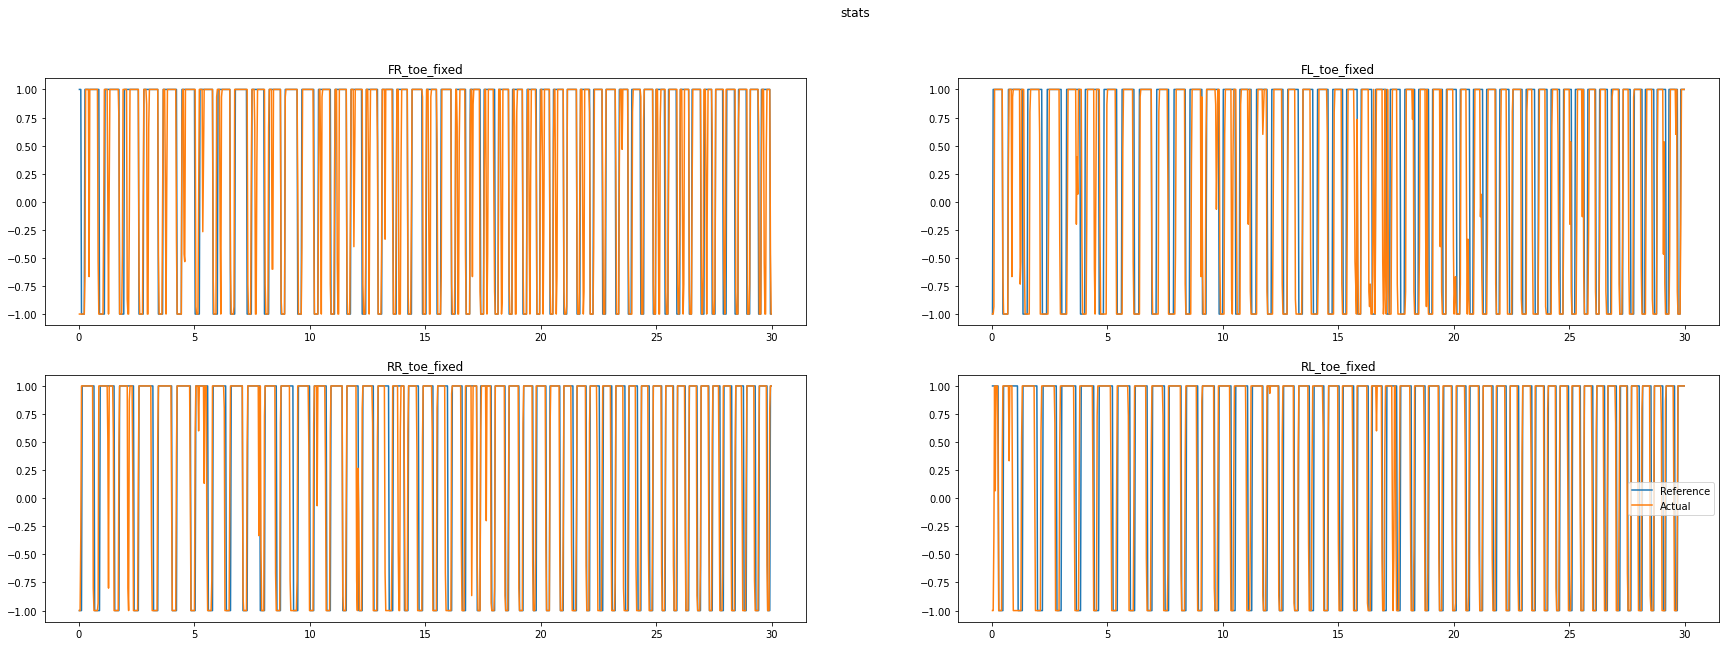

In [18]:
model_dir = project_dir / 'logs/locomotion_baselines' / 'ppo' / 'A1GymEnv-v0_6'
stats_dirs = [
    model_dir / 'stats'
    # model_dir / 'test_var_duty' / f'duty_{duty}' \
    #     for duty in (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85)
]
# stats_dir1 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_1.0Hz_alpha_10.0'
# stats_dir2 = model_dir / 'experiments' / 'vary_freq' / 'train_1.0Hz_test_2.0Hz'

statss = [load_robot_states(sd) for sd in stats_dirs]
normalizer = load_normalizer(model_dir)

NUM_TIMESTEPS = 999

def plot_foot_contact_sequence(stats, stats_dir, normalizer):
    import matplotlib.pyplot as plt 
    
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, 46:50]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    # Every cycle will result in an overall +4 to the absolute difference of consec. terms
    num_cycles = np.sum(np.abs(ref_foot_contacts[:-1] - ref_foot_contacts[1:]), axis=0) / 4
    print(num_cycles)
    
    plt.figure()
    plt.title(f"Reference {stats_dir.name}")
    plt.ylim(0.5, 4.5)
    for i in range(4):    
        plt.scatter(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i] * (i+1), label = foot_names[i])
    plt.legend()

    
    fig, ax = plt.subplots(2,2, figsize=(30,10))
    fig.suptitle(stats_dir.name)
    idxes = [(0,0), (0,1), (1,0), (1,1)]
    for i in range(4):
        ax[idxes[i]].set_title(f"{foot_names[i]}")
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], ref_foot_contacts[:NUM_TIMESTEPS, i], label = 'Reference')
        ax[idxes[i]].plot(time[:NUM_TIMESTEPS], act_foot_contacts[:NUM_TIMESTEPS, i], label = 'Actual')
        plt.legend()

for stats, stats_dir in zip(statss, stats_dirs):
    plot_foot_contact_sequence(stats, stats_dir, normalizer)
    

FR_toe_fixed 0.748419525345143 3.5135643259170477e-180
FL_toe_fixed 0.6720268728401656 2.376999280111583e-132
RR_toe_fixed 0.7708376028155789 1.1687750243637386e-197
RL_toe_fixed 0.6829934012890171 2.603522267271393e-138

FR_toe_fixed 0.7603999911374958
FL_toe_fixed 0.6146000100262449
RR_toe_fixed 0.7547333251273747
RL_toe_fixed 0.7075999921334527



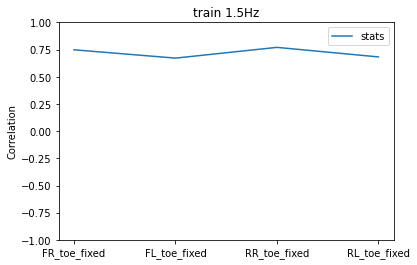

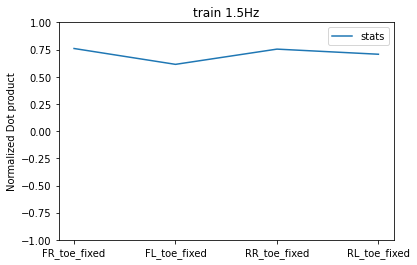

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

def compute_correlation(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, 46:50]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    corrs = np.zeros(4,)
    for i in range(4):
        corr, p = spearmanr(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        print(foot_names[i], corr, p)
        corrs[i] = corr
    ax.plot(foot_names, corrs, label=label)

def compute_dot_prod(stats, normalizer, ax, label=None):
    time = stats[0]
    nn_obs = stats[4]
    raw_obs = normalizer.unnormalize_obs(nn_obs)
    ref_foot_contacts = raw_obs[:, 0, 46:50]
    act_foot_contacts = (0.03 - 2 * stats[3]) / 0.03
    dot_prods = np.zeros(4,)
    for i in range(4):
        dot_prod = np.dot(act_foot_contacts[:,i], ref_foot_contacts[:,i])
        dot_prod = dot_prod / (ref_foot_contacts[:,i] ** 2).sum(axis=0) 
        print(foot_names[i], dot_prod)
        dot_prods[i] = dot_prod
    ax.plot(foot_names, dot_prods, label=label)
    
labels = [sd.name for sd in stats_dirs]

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))

# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_correlation(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Correlation")
ax.legend()

fig, ax = plt.subplots()
ax.set_ylim((-1.0, 1.0))
# labels = ['test_1.0Hz', 'test_1.5Hz', 'test_2.0Hz']
for i, stats in enumerate(statss):
    compute_dot_prod(stats, normalizer, ax, label = labels[i])
    print()
ax.set_title("train 1.5Hz")
ax.set_ylabel("Normalized Dot product")
ax.legend()